In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier 
#from sklearn.learning_curve import learning_curve


import nltk
import warnings
warnings.filterwarnings('ignore')



In [2]:

data = pd.read_csv('C:/Users/anjal/Downloads/spam.csv', encoding='latin-1')
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v2" : "text", "v1":"label"})
data['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

array([[<Axes: title={'center': 'length'}>]], dtype=object)

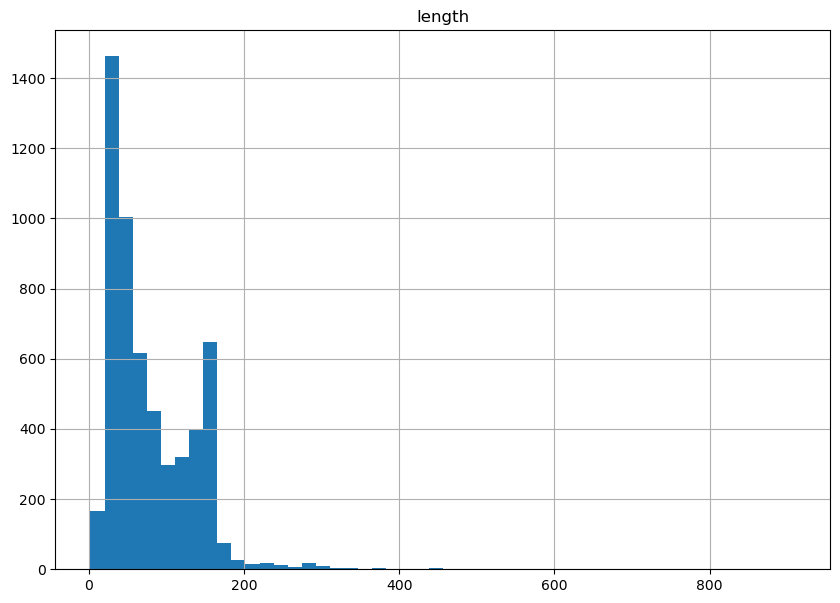

In [3]:
data['length'] = data['text'].map(lambda x: len(x))
data.hist(column='length', bins=50, figsize=(10,7))


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

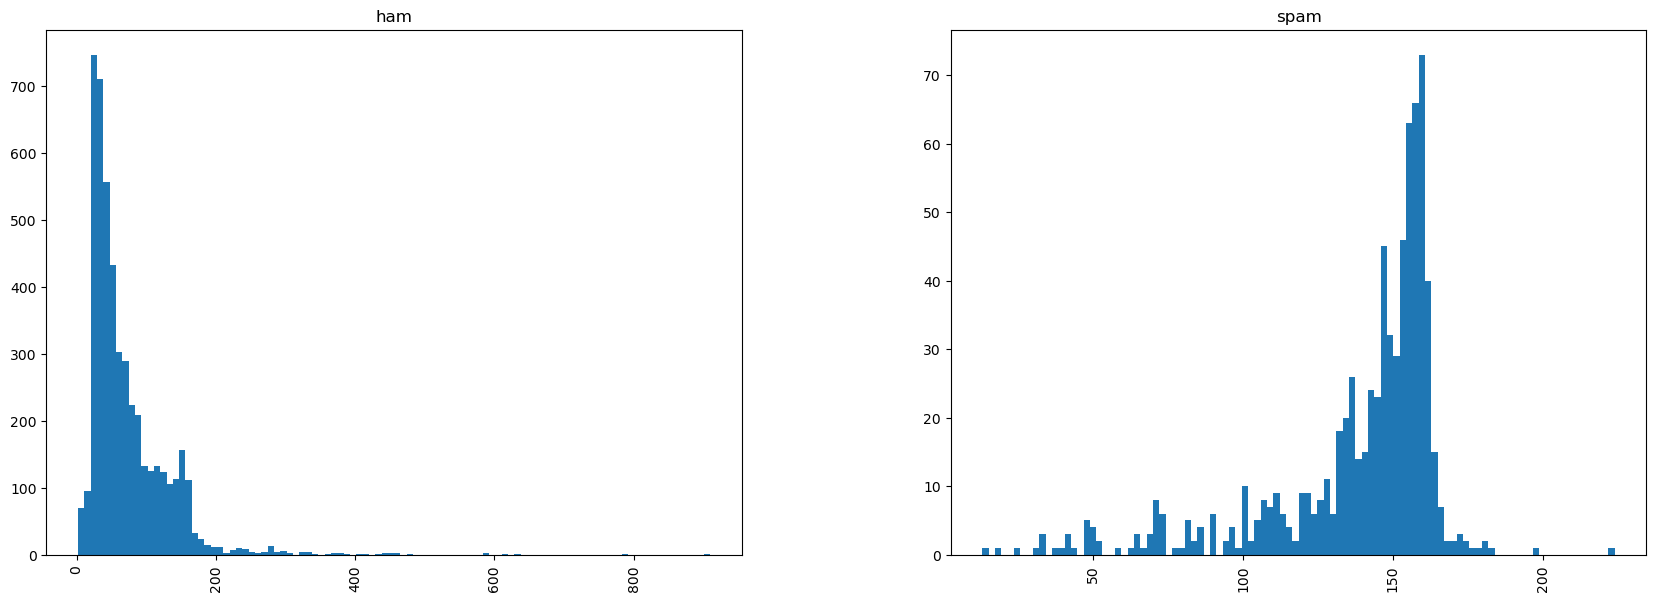

In [4]:
data.hist(column='length', by='label', bins=100, figsize=(20,7))

In [5]:
ham_words = ''
spam_words = ''
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

In [6]:
for val in data[data['label'] == 'ham'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

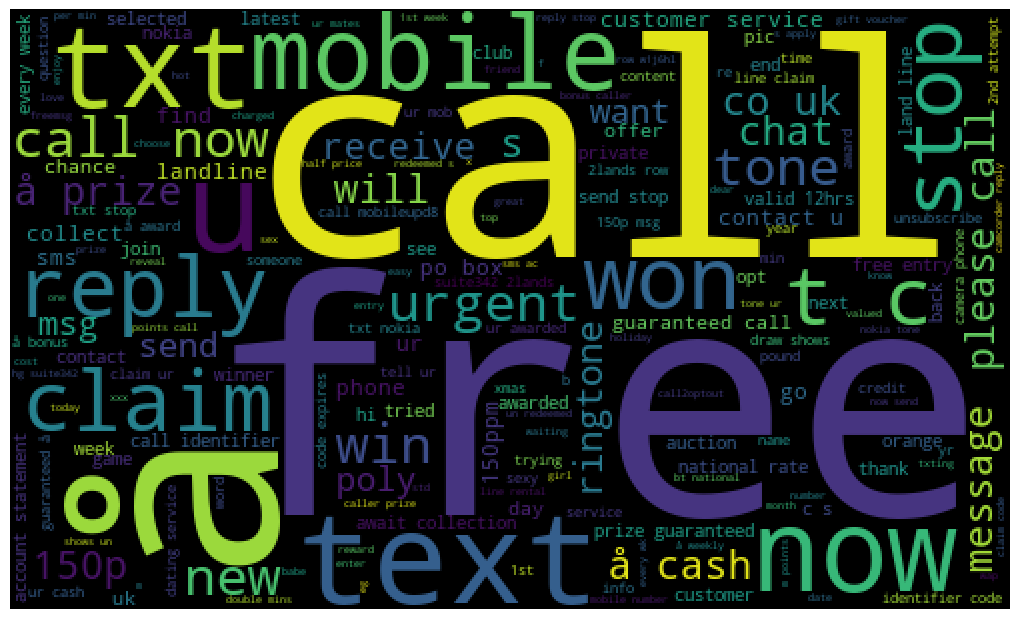

In [7]:
plt.figure(figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

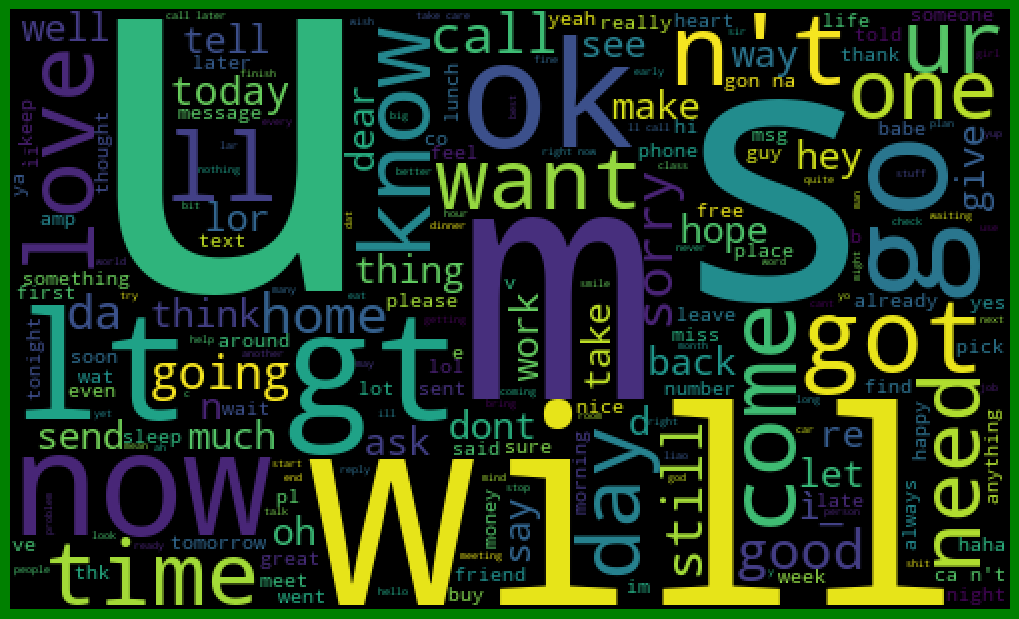

In [8]:
plt.figure(figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

data = data.replace(['ham','spam'],[0, 1]) 

In [9]:
import string
def text_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

In [10]:
data['text'] = data['text'].apply(text_process)
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])

In [11]:
from collections import Counter
total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

vocab = sorted(total_counts, key=total_counts.get, reverse=True)

In [12]:
vocab_size = len(vocab)
word2idx = {}
for i, word in enumerate(vocab):
    word2idx[word] = i

In [13]:
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [14]:
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for ii, (_, text_) in enumerate(text.iterrows()):
    word_vectors[ii] = text_to_vector(text_[0])

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])

features = vectors

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

In [17]:
import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)

In [18]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [19]:
watchlist = [(d_train, 'train')]

In [20]:
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=400, verbose_eval=10)


[0]	train-error:0.13429
[10]	train-error:0.13429
[20]	train-error:0.13429
[30]	train-error:0.06398
[40]	train-error:0.04645
[50]	train-error:0.03948
[60]	train-error:0.03568
[70]	train-error:0.03294
[80]	train-error:0.03209
[90]	train-error:0.02935
[100]	train-error:0.02639
[110]	train-error:0.02534
[120]	train-error:0.02449
[130]	train-error:0.02407
[140]	train-error:0.02407
[150]	train-error:0.02407
[160]	train-error:0.02365
[170]	train-error:0.02280
[180]	train-error:0.02196
[190]	train-error:0.02069
[200]	train-error:0.02006
[210]	train-error:0.01879
[220]	train-error:0.01879
[230]	train-error:0.01858
[240]	train-error:0.01816
[250]	train-error:0.01816
[260]	train-error:0.01753
[270]	train-error:0.01753
[280]	train-error:0.01689
[290]	train-error:0.01689
[300]	train-error:0.01605
[310]	train-error:0.01626
[320]	train-error:0.01626
[330]	train-error:0.01562
[340]	train-error:0.01562
[350]	train-error:0.01520
[360]	train-error:0.01499
[370]	train-error:0.01499
[380]	train-error:0.014

In [21]:


from sklearn.metrics import accuracy_score



In [22]:

d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

npround = np.vectorize(round)
p_test_ints = npround(p_test)

accuracy = accuracy_score(y_test, p_test_ints)
print("Test Accuracy: ", accuracy)


Test Accuracy:  0.972488038277512


In [23]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier



In [24]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))



In [25]:
pred_scores_dict = dict(pred_scores_word_vectors)
predictions = pd.DataFrame.from_dict(pred_scores_dict,orient='index', columns=['Score'])
predictions


,Score
SVC,0.978469
KN,0.933014
NB,0.988038
DT,0.960526
LR,0.953349
RF,0.979665


In [26]:
predictions_word_vectors = pd.DataFrame.from_dict(pred_scores_dict,orient='index', columns=['Score_'])
predictions_word_vectors


,Score_
SVC,0.978469
KN,0.933014
NB,0.988038
DT,0.960526
LR,0.953349
RF,0.979665


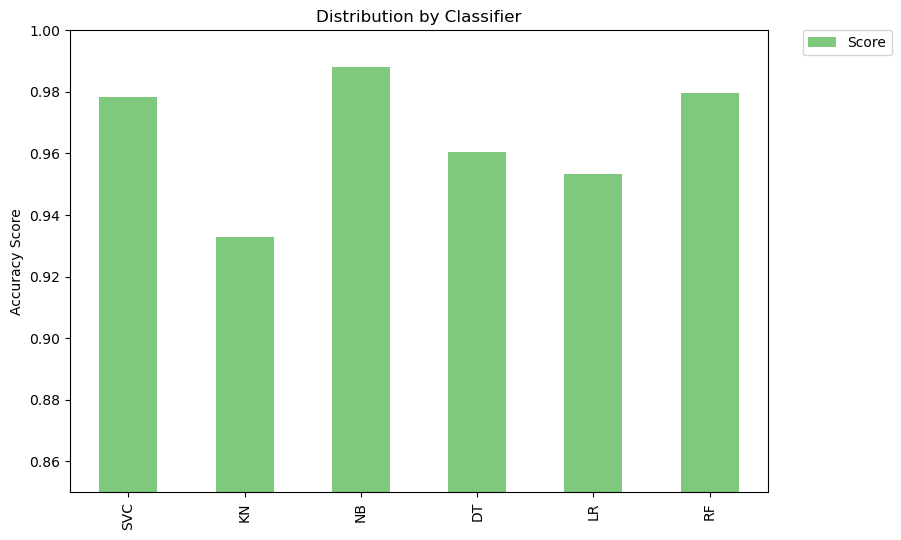

In [27]:
predictions.plot(kind='bar', ylim=(0.85, 1.0), figsize=(9, 6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [28]:
def find(p):
    if p == 1:
        print("Message is SPAM")
    else:
        print("Message is NOT Spam")

text = ["Free tones Hope you enjoyed your new content"]
integers = vectorizer.transform(text)
p = mnb.predict(integers)[0]
find(p)

Message is SPAM


In [29]:
import joblib
joblib.dump(mnb, 'best.pkl')
print("Best Model (Naive Bayes) Saved")

Best Model (Naive Bayes) Saved


In [30]:
best = joblib.load('best.pkl')
best



MultinomialNB(alpha=0.2)

In [31]:
# Testing our classifiers
text1 = ["Free tones Hope you enjoyed your new content"]
text2 = ["No. I meant the calculation is the same. That I'll call later"]
text3 = ["Had your contract mobile 11 Mnths? Latest Motorola Now"]
text4 = ["WINNER!! You just won a free ticket to Bahamas. Send your Details"]

integers1 = vectorizer.transform(text1)
integers2 = vectorizer.transform(text2)
integers3 = vectorizer.transform(text3)
integers4 = vectorizer.transform(text4)
p1 = best.predict(integers1)[0]
p2 = best.predict(integers2)[0]
p3 = best.predict(integers3)[0]
p4 = best.predict(integers4)[0]

find(p1)
find(p2)
find(p3)
find(p4)


Message is SPAM
Message is NOT Spam
Message is SPAM
Message is SPAM
